In [2]:
'''

application of calculate ocean heat budget II


good ref. slides
https://www.ecco-group.org/docs/ss_ThompsonECCO.pdf

'''

'\n\napplication of calculate ocean heat budget II\n\n\ngood ref. slides\nhttps://www.ecco-group.org/docs/ss_ThompsonECCO.pdf\n\n'

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import xarray as xr
from scipy.io import loadmat
from scipy.interpolate import interp2d, NearestNDInterpolator

In [4]:
import os
os.getcwd()

%cd /g/data/p66/ars599/EAE_Lecture

/g/data/p66/ars599/EAE_Lecture


In [5]:
idir = '/g/data/p66/ars599/work_eae/'
filenames = [idir+'ts_Amon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912.nc',
            idir+'tas_Amon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912.nc',
            idir+'uas_Amon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912.nc',
            idir+'vas_Amon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912.nc', 
            idir+'hfls_Amon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912.nc',
            idir+'hfss_Amon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912.nc',
            idir+'huss_Amon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912.nc',
            idir+'rlds_Amon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912.nc',
            idir+'rlus_Amon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912.nc',
            idir+'rsds_Amon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912.nc',
            idir+'rsus_Amon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912.nc',
            idir+'psl_Amon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912.nc']

file_list = []

for filename in filenames:
    ds = xr.open_dataset(filename)
    file_list.append(ds)

#file_list

In [6]:
lon1, lon2 = [0,360]
lat1, lat2 = [-90,90]

rsds = file_list[9]['rsds'].sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
rsus = file_list[10]['rsus'].sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))

ts = file_list[0]['ts'].sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
tas = file_list[1]['tas'].sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
rlds = file_list[7]['rlds'].sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
rlus = file_list[8]['rlus'].sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))

uas = file_list[2]['uas'].sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
vas = file_list[3]['vas'].sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
hfss = file_list[5]['hfss'].sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
hfls = file_list[4]['hfls'].sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))

# hfls
psl = file_list[11]['psl'].sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
huss = file_list[6]['huss'].sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))

x_ts = ts.lon
y_ts = ts.lat

x_tas = tas.lon
y_tas = tas.lat

# 1) SW

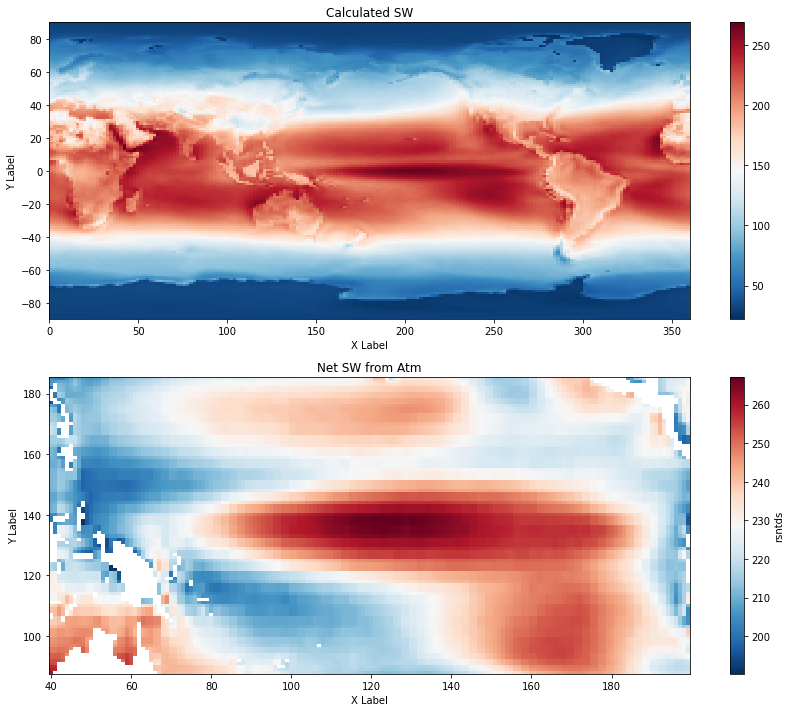

In [7]:
SW = rsds - rsus

filename = idir+'rsntds_Omon_ACCESS-CM2_historical_r5i1p1f1_gn_200001-200912_v10.nc'
ds = xr.open_dataset(filename)
rsntds = ds['rsntds']
net_sw = rsntds

import matplotlib.colors as mcolors

fig, axes = plt.subplots(nrows=2, figsize=(12, 10))
# Custom colormap with different levels
cmap = plt.get_cmap('RdBu_r')
bounds = [0, 50, 100, 150, 200, 210, 220, 230, 240, 250, 260]
norm = mcolors.BoundaryNorm(bounds, cmap.N)


plt.subplot(211)
SW.mean('time').plot(ax=axes[0], cmap=cmap)
axes[0].set_title('Calculated SW')
axes[0].set_xlabel('X Label')
axes[0].set_ylabel('Y Label')
plt.subplot(212)
net_sw.mean('time').plot(ax=axes[1], cmap=cmap)
axes[1].set_title('Net SW from Atm')
axes[1].set_xlabel('X Label')
axes[1].set_ylabel('Y Label')

plt.tight_layout()
plt.show()

# 2) LW

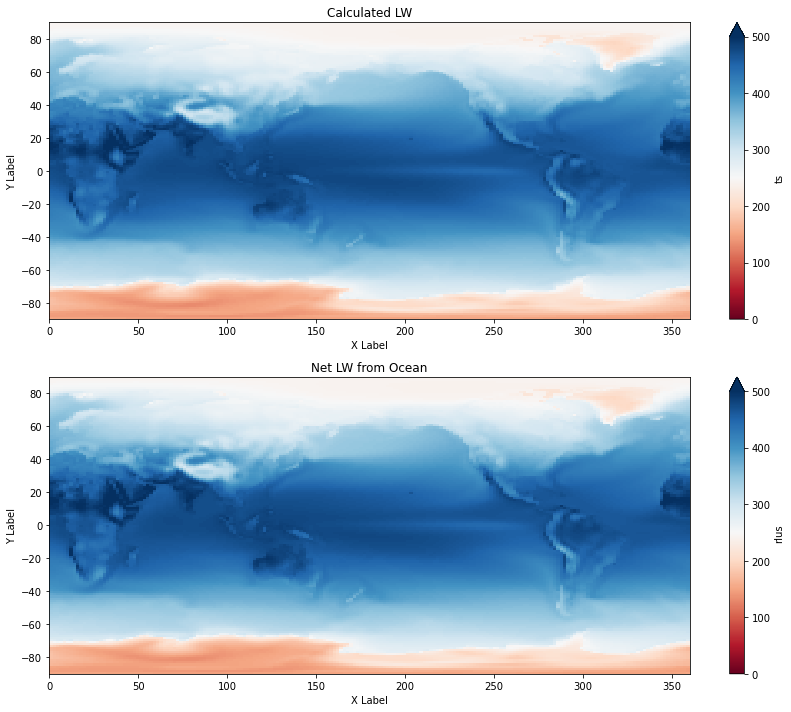

In [8]:
'''
https://iopscience.iop.org/article/10.1088/1748-9326/ac153c

E: is the radiation intensity in W/m2
epsilon: an adimensional coefficient that represents the emissivity of the body. 
         This depends on the material, a perfect black body has an epsilon of 1,
         while other materials have a lower emissivity
sigmma: is the Steffan-Boltzman constant 5.67x10^-8 W/M2/K4
T is the body temperature in K

'''

net_lw = rlus.mean('time')

epsilon = 1
sigmma = 5.67*10**-8
LW = epsilon * sigmma * ts**4

fig = plt.figure(figsize=(12, 10))

plt.subplot(211)
LW.mean('time').plot(cmap='RdBu',vmin=0,vmax=500)
plt.title('Calculated LW')
plt.xlabel('X Label')
plt.ylabel('Y Label')
plt.subplot(212)
net_lw.plot(cmap='RdBu',vmin=0,vmax=500)
plt.title('Net LW from Ocean')
plt.xlabel('X Label')
plt.ylabel('Y Label')

plt.tight_layout()
plt.show()

# 3) HFLS

In [9]:
# Create interpolation variables
uas_regrid = uas.interp(lat=vas.lat, lon=vas.lon)
ts_regrid = ts.interp(lat=vas.lat, lon=vas.lon)
tas_regrid = tas.interp(lat=vas.lat, lon=vas.lon)
huss_regrid = huss.interp(lat=vas.lat, lon=vas.lon)
psl_regrid = psl.interp(lat=vas.lat, lon=vas.lon)

qas = huss_regrid


Text(0, 0.5, 'Y Label')

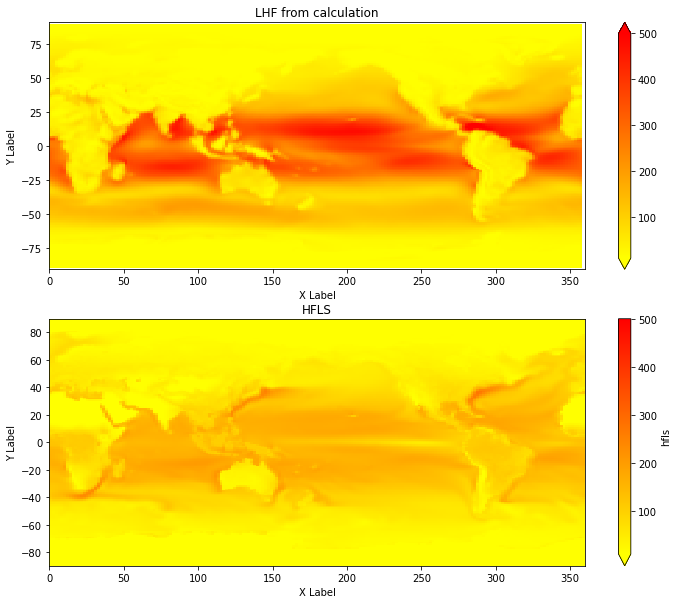

In [10]:
'''
  HFLS:  QL=Lr*ho*CL*U*(qo-qa)
'''
Lv = 2.5008*10**6 - 2.3*10**3*ts_regrid
CLH = 1.5 * 10**-3
rho = 1.275

# Define the condition
condition = (ts_regrid > 100) & (tas_regrid > 100)
# Use the where function to modify values based on the condition
ts_regrid = ts_regrid.where(~condition, ts_regrid - 273.15)
tas_regrid = tas_regrid.where(~condition, tas_regrid - 273.15)

e_ts = 6.112*np.exp(17.67*ts_regrid/(ts_regrid+243.5))
q_ts=0.622*e_ts/(psl_regrid-0.378*e_ts)
qas = huss_regrid

wind = np.sqrt(uas_regrid**2 + vas**2)
delta_q = qas - q_ts
LHF = rho*wind*Lv*CLH*delta_q

fig = plt.figure(figsize=(12, 10))

plt.subplot(211)
LHF.mean('time').plot(cmap='autumn_r',vmin=10,vmax=500)
plt.title('LHF from calculation')
plt.xlabel('X Label')
plt.ylabel('Y Label')
plt.subplot(212)
hfls.mean('time').plot(cmap='autumn_r',vmin=10,vmax=500)
plt.title('HFLS')
plt.xlabel('X Label')
plt.ylabel('Y Label')

# 4) HFSS

Text(0, 0.5, 'Y Label')

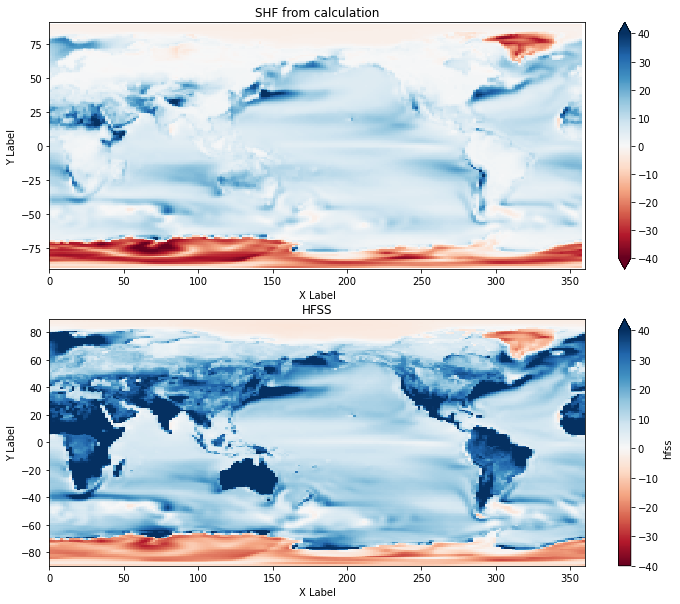

In [11]:
'''
  HFSS: Qs = Cp*rho*Cs*U(To-Ta)
'''
Cp = 1005.5
rho = 1.275
CSH = 1.5e-3

# Calculate wind speed using uas_regrid and vas
wind = np.sqrt(uas_regrid**2 + vas**2)

delta_t = ts_regrid - tas_regrid
SHF = rho*wind*Cp*CSH*delta_t

fig = plt.figure(figsize=(12, 10))

plt.subplot(211)
SHF.mean('time').plot(cmap='RdBu',vmin=-40,vmax=40)
plt.title('SHF from calculation')
plt.xlabel('X Label')
plt.ylabel('Y Label')
plt.subplot(212)
hfss.mean('time').plot(cmap='RdBu',vmin=-40,vmax=40)
plt.title('HFSS')
plt.xlabel('X Label')
plt.ylabel('Y Label')

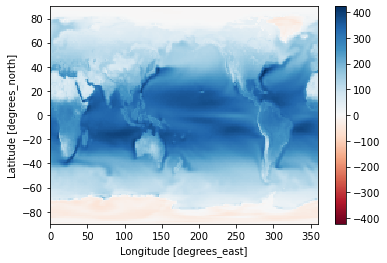

In [13]:
# Calculate net surface heat flux
net_surface_heat_flux = hfss + hfls + (rlds - rlus) + (rsds - rsus)
net_surface_heat_flux.mean('time').plot(cmap='RdBu')

# Create a zonal advection Dataset containing the DataArrays
data_dict = {
    'net_surface_heat_flux' : net_surface_heat_flux,
}
ds = xr.Dataset(data_dict)

# Save the Dataset to a netCDF file
ds.to_netcdf('net_surface_heat_flux.nc')